In [2]:
# matplotlib==3.5.0 is required for tikzplotlib to work 
# see https://github.com/texworld/tikzplotlib/pull/558
!pip install tikzplotlib numpy matplotlib==3.5.0 scipy Pillow


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import re
import numpy as np
from scipy.spatial import distance_matrix
from scipy.spatial.distance import cdist

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
import tikzplotlib

In [2]:
print(tikzplotlib.Flavors.latex.preamble())

\documentclass{standalone}
\usepackage[utf8]{inputenc}
\usepackage{pgfplots}
\DeclareUnicodeCharacter{2212}{−}
\usepgfplotslibrary{groupplots,dateplot}
\usetikzlibrary{patterns,shapes.arrows}
\pgfplotsset{compat=newest}



In [2]:
darkred = "#8b0000"
darkgreen = "#006400"

EXPORT_ROOT = "../images/"

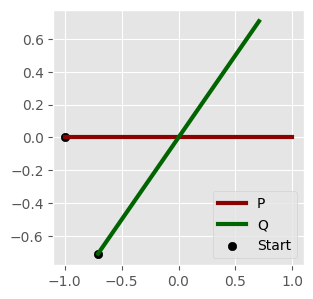

In [4]:
# Free space bird from paper
# p_coord = [[-1, -0.5], [0.5, 0.5], [-0.5,1], [-0.5,-0.5], [0.4, -0.15], [0.6, -0.3]]
# q_coord = [[-0.5, -1], [-1,0], [0,0], [0,1], [-1,0.5], [0.5,-0.5],]

# Two line segmens
p_coord = [[-1,0], [1,0]]
q_coord = [[np.cos(np.pi + np.pi/4), np.sin(np.pi + np.pi/4)], [np.cos(np.pi/4), np.sin(np.pi/4)]]

# p_coord = [[0,0.8], [0,1], [1.25,1], [1.4,0.9], [1.5,1], [2,1]]
# q_coord = [[-0.1,1], [1,1.1], [1.5,1.3], [1.8,1], [2,1]]

pxs, pys = zip(*p_coord)
qxs, qys = zip(*q_coord)


plt.style.use("ggplot")
fig, ax = plt.subplots(1, figsize=(10,10))

p_plot, = ax.plot(pxs, pys, label="P", color=darkred, linewidth=3)
q_plot, = ax.plot(qxs, qys, label="Q", color=darkgreen, linewidth=3)
startpoints = ax.scatter([pxs[0], qxs[0]], [pys[0], qys[0]], c='black', label="Start")

ax.set_xbound(lower=-1.1, upper=1.1)
ax.legend(handles = [p_plot, q_plot, startpoints], frameon=True, loc='lower right')

plt.tight_layout()
factor = 1
plt.gcf().set_size_inches(2.70134 * factor, 2.70134 * factor)

plt.savefig(EXPORT_ROOT + "/frechet_distance/line_segments.pdf", format="pdf")
tikzplotlib.clean_figure()
tikzplotlib.save(EXPORT_ROOT + "/frechet_distance/line_segments.tex", strict=True, axis_width='\\textwidth', axis_height='\\textwidth')

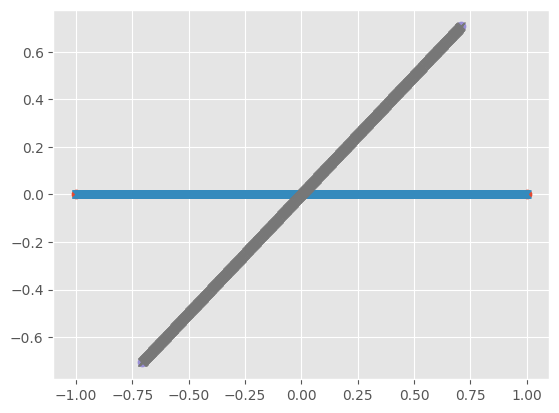

In [5]:
POINTS_PER_LINE_SEGMENT = 1000

# https://stackoverflow.com/a/40624614/ @Divakar
def create_ranges(start, stop, N, endpoint=True):
    if endpoint==1:
        divisor = N-1
    else:
        divisor = N
    steps = (1.0/divisor) * (stop - start)
    return steps[:,None]*np.arange(N) + start[:,None]

def ranges_based(a,N):
    ranges2D = create_ranges(a[:-1],a[1:],N-1,endpoint=False)
    return np.concatenate((ranges2D.ravel(),[a[-1]]))

def interpolate_polygonal_curve(polygonal_curve):
  diffs = np.diff(polygonal_curve, axis=0) # get distance vectors between points
  dists = np.linalg.norm(diffs, ord=2, axis=1) # eucledian distance between points
  # dist = np.sum(dists) # total length of curve

  # insert "0" at the start of the array
  distance_sample_points = np.insert(np.cumsum(dists), 0, 0, axis=0)

  x_coords, y_coords = zip(*polygonal_curve)

  
  new_intervals = ranges_based(distance_sample_points, POINTS_PER_LINE_SEGMENT)
  new_x_coords = np.interp(new_intervals, distance_sample_points, x_coords)
  new_y_coords = np.interp(new_intervals, distance_sample_points, y_coords)

  return np.vstack((new_x_coords, new_y_coords)).T

# Plot P
x_coords, y_coords = zip(*p_coord)
new_p_coords = interpolate_polygonal_curve(p_coord)
new_x_p_coords, new_y_q_coords = np.moveaxis(new_p_coords, 1, 0)

plt.plot(x_coords, y_coords, '-o')
plt.plot(new_x_p_coords, new_y_q_coords, '-x')


# Plot Q
x_coords, y_coords = zip(*q_coord)
new_q_coords = interpolate_polygonal_curve(q_coord)
new_x_q_coords, new_y_q_coords = np.moveaxis(new_q_coords, 1, 0)

plt.plot(x_coords, y_coords, '-o')
plt.plot(new_x_q_coords, new_y_q_coords, '-x')

plt.show()

In [6]:
palette = np.array([[245, 245, 245],   # white
                    [30, 30, 30],   # black border
                    [150, 150, 150],   # gray
                    ])

0.7653668647301795 0.7653668647301795


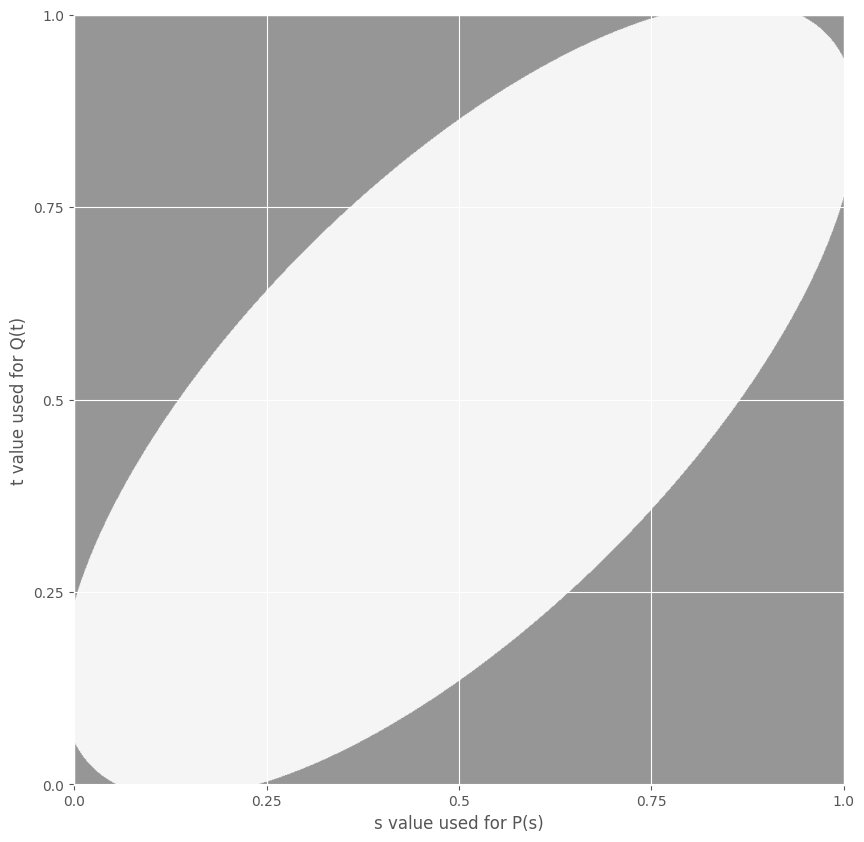

In [7]:
dists = distance_matrix(new_p_coords, new_q_coords)

print(dists[0,0], dists[-1,-1])
threshold = 0.73
epsilon = 0

plot_pixels = np.zeros_like(dists, dtype="int")
plot_pixels[dists  >= threshold + epsilon] = 2
plot_pixels[(dists  < threshold + epsilon) & (dists  > threshold - epsilon)] = 1
plot_pixels[dists  <= threshold - epsilon] = 0


plt.style.use("ggplot")
fig, ax = plt.subplots(1, figsize=(10,10))


ax.imshow(palette[plot_pixels.T])
# plt.colorbar()
ax.invert_yaxis()
ax.set_xlabel("s value used for P(s)")
ax.set_ylabel("t value used for Q(t)")
ax.set_xticks(np.linspace(0, len(new_p_coords), num=5), np.linspace(0,1, num=5))
ax.set_yticks(np.linspace(0, len(new_q_coords), num=5), np.linspace(0,1, num=5))

filename = "free_space_single_cell"
plt.savefig(EXPORT_ROOT + "/frechet_distance/" + filename + ".pdf", format="pdf")

tex_path = EXPORT_ROOT + "/frechet_distance/" + filename + ".tex"
tikzplotlib.clean_figure()
tikzplotlib.save(tex_path, strict=True, axis_width='\\textwidth', axis_height='\\textwidth')

# post processing of plot
# fix relative path
with open(tex_path, "r") as f:
    tex = f.read()
matches = re.search(r"\{(.+\.png)\};", tex)
png_file_name = matches.groups(0)[0]
tex = tex.replace(png_file_name, "images/frechet_distance/" + filename + "_image.png")
with open(tex_path, "w") as f:
    f.write(tex)

# fix image orientation
png_path = EXPORT_ROOT + "/frechet_distance/" + png_file_name
original_img = Image.open(png_path)
original_img = original_img.transpose(method=Image.Transpose.FLIP_TOP_BOTTOM)
original_img.save(EXPORT_ROOT + "/frechet_distance/" + filename + "_image.png")
original_img.close()

In [9]:
np.save("free_space_cell_points.npy", palette[plot_pixels.T])

In [12]:
plot_pixels.T.shape

(1000, 1000)

In [17]:
import matplotlib.image

matplotlib.image.imsave('free_space_cell_points.png', np.flip(palette[plot_pixels], 0).astype(np.uint8))

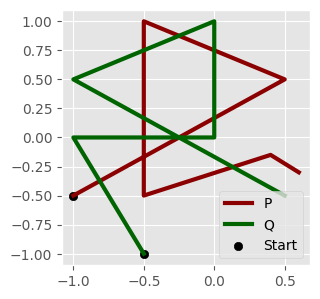

In [18]:
# Free space bird from paper
p_coord = [[-1, -0.5], [0.5, 0.5], [-0.5,1], [-0.5,-0.5], [0.4, -0.15], [0.6, -0.3]]
q_coord = [[-0.5, -1], [-1,0], [0,0], [0,1], [-1,0.5], [0.5,-0.5]]

pxs, pys = zip(*p_coord)
qxs, qys = zip(*q_coord)

plt.style.use("ggplot")
fig, ax = plt.subplots(1, figsize=(10,10))
p_plot, = ax.plot(pxs, pys, label="P", color=darkred, linewidth=3)
q_plot, = ax.plot(qxs, qys, label="Q", color=darkgreen, linewidth=3)
startpoints = ax.scatter([pxs[0], qxs[0]], [pys[0], qys[0]], c='black', label="Start")
ax.legend(handles = [p_plot, q_plot, startpoints], frameon=True, loc='lower right')

plt.tight_layout()
factor = 1
plt.gcf().set_size_inches(2.70134 * factor, 2.70134 * factor)

plt.savefig(EXPORT_ROOT + "/frechet_distance/polygonal_curves.pdf", format="pdf")
tikzplotlib.clean_figure()
tikzplotlib.save(EXPORT_ROOT + "/frechet_distance/polygonal_curves.tex", strict=True, axis_width='\\textwidth', axis_height='\\textwidth')

In [19]:
new_p_coords = interpolate_polygonal_curve(p_coord)
new_q_coords = interpolate_polygonal_curve(q_coord)
dists = distance_matrix(new_p_coords, new_q_coords)

0.7071067811865476 0.22360679774997896


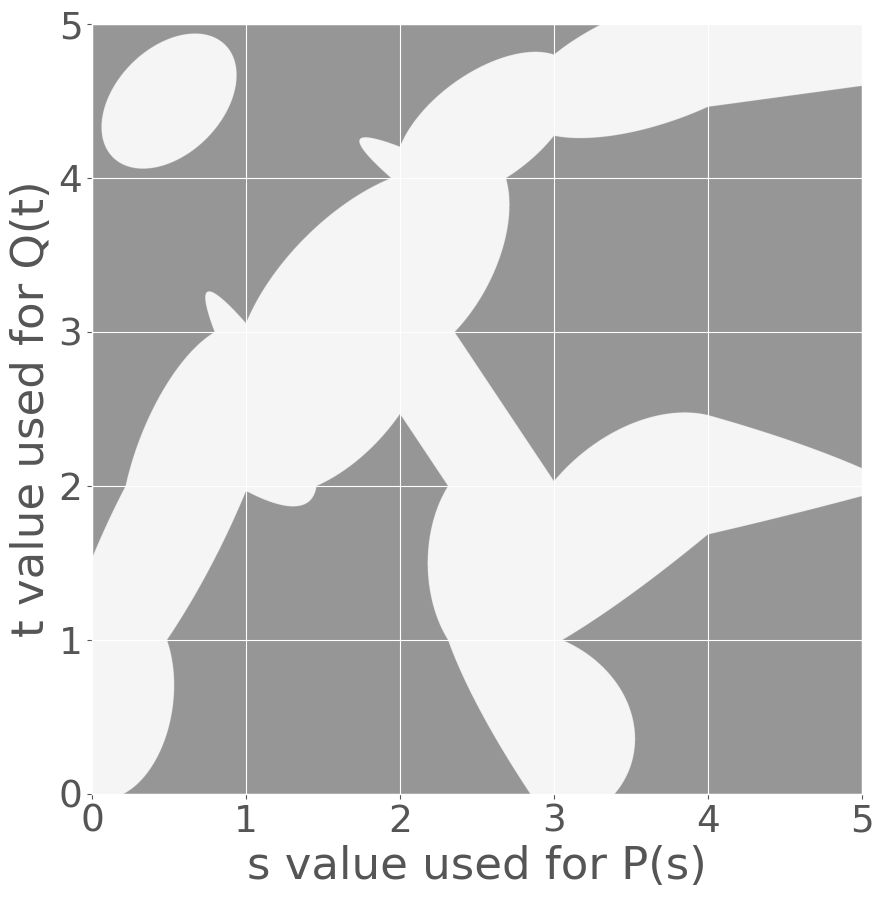

In [20]:
print(dists[0,0], dists[-1,-1])
threshold = 0.73
epsilon = 0

plot_pixels = np.zeros_like(dists, dtype="int")
plot_pixels[dists  >= threshold + epsilon] = 2
plot_pixels[(dists  < threshold + epsilon) & (dists  > threshold - epsilon)] = 1
plot_pixels[dists  <= threshold - epsilon] = 0


plt.style.use("ggplot")
plt.rc('font', size=27)
fig, ax = plt.subplots(1, figsize=(10,10))


ax.imshow(palette[plot_pixels.T])


ax.invert_yaxis()
ax.set_xlabel("s value used for P(s)")
ax.set_ylabel("t value used for Q(t)")
ax.set_xticks(np.linspace(0, len(new_p_coords)-1, num=len(p_coord)), np.arange(0,len(p_coord)))
ax.set_yticks(np.linspace(0, len(new_q_coords)-1, num=len(q_coord)), np.arange(0,len(q_coord)))

filename = "free_space_polygonal_curves"
plt.savefig(EXPORT_ROOT + "/frechet_distance/" + filename + ".pdf", format="pdf")

tex_path = EXPORT_ROOT + "/frechet_distance/" + filename + ".tex"
tikzplotlib.clean_figure()
tikzplotlib.save(tex_path, strict=True, axis_width='\\textwidth', axis_height='\\textwidth')

# post processing of plot
# fix relative path
with open(tex_path, "r") as f:
    tex = f.read()
matches = re.search(r"\{(.+\.png)\};", tex)
png_file_name = matches.groups(0)[0]
tex = tex.replace(png_file_name, "images/frechet_distance/" + filename + "_image.png")
with open(tex_path, "w") as f:
    f.write(tex)

# fix image orientation
png_path = EXPORT_ROOT + "/frechet_distance/" + png_file_name
original_img = Image.open(png_path)
original_img = original_img.transpose(method=Image.Transpose.FLIP_TOP_BOTTOM)
original_img.save(EXPORT_ROOT + "/frechet_distance/" + filename + "_image.png")
original_img.close()


In [22]:
import matplotlib.image

matplotlib.image.imsave('free_space_diagram_points.png', np.flip(palette[plot_pixels.T], 0).astype(np.uint8))

0.7071067811865476 0.22360679774997896


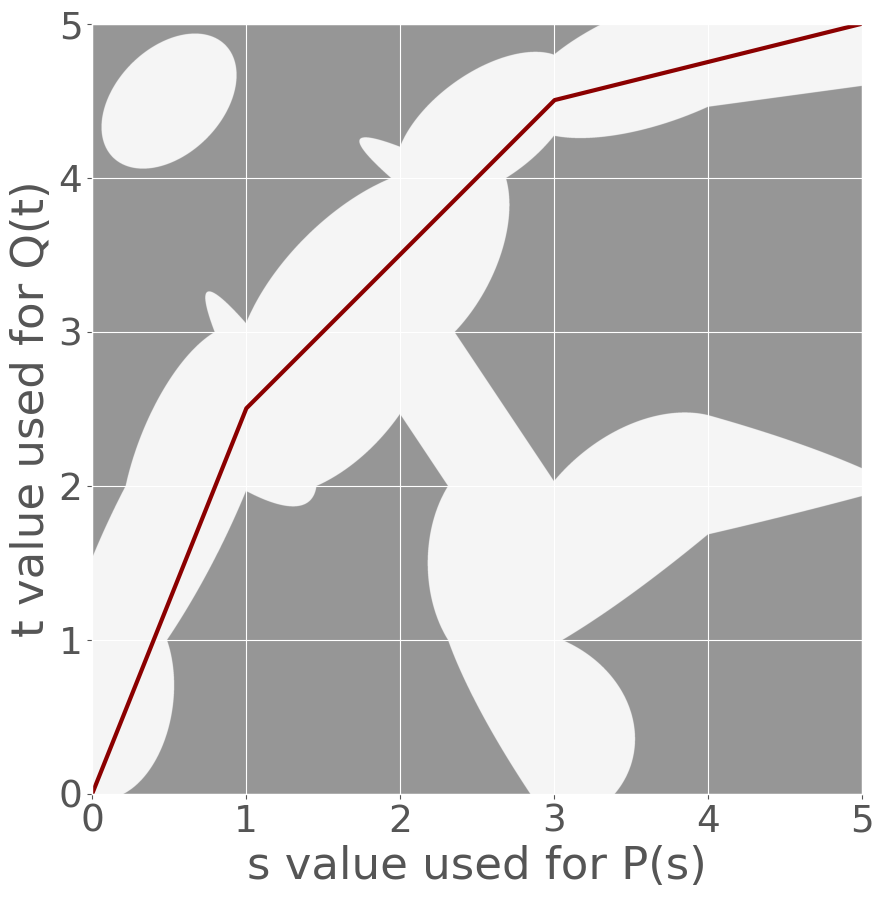

In [112]:
print(dists[0,0], dists[-1,-1])
threshold = 0.73
epsilon = 0

plot_pixels = np.zeros_like(dists, dtype="int")
plot_pixels[dists  >= threshold + epsilon] = 2
plot_pixels[(dists  < threshold + epsilon) & (dists  > threshold - epsilon)] = 1
plot_pixels[dists  <= threshold - epsilon] = 0


plt.style.use("ggplot")
plt.rc('font', size=27)
fig, ax = plt.subplots(1, figsize=(10,10))

curve_coords = [[0,0], [1000,2500], [3000,4500], [len(new_p_coords), len(new_q_coords)]]
curve_x, curve_y = zip(*curve_coords)
p_plot, = ax.plot(curve_x, curve_y, color=darkred, linewidth=3)

ax.imshow(palette[plot_pixels.T])

ax.invert_yaxis()
ax.set_xlabel("s value used for P(s)")
ax.set_ylabel("t value used for Q(t)")
ax.set_xticks(np.linspace(0, len(new_p_coords)-1, num=len(p_coord)), np.arange(0,len(p_coord)))
ax.set_yticks(np.linspace(0, len(new_q_coords)-1, num=len(q_coord)), np.arange(0,len(q_coord)))

filename = "free_space_monotone_curve"
plt.savefig(EXPORT_ROOT + "/frechet_distance/" + filename + ".pdf", format="pdf")

tex_path = EXPORT_ROOT + "/frechet_distance/" + filename + ".tex"
tikzplotlib.clean_figure()
tikzplotlib.save(tex_path, strict=True, axis_width='\\textwidth', axis_height='\\textwidth')

# post processing of plot
# fix relative path
with open(tex_path, "r") as f:
    tex = f.read()
matches = re.search(r"\{(.+\.png)\};", tex)
png_file_name = matches.groups(0)[0]
tex = tex.replace(png_file_name, "images/frechet_distance/" + filename + "_image.png")
with open(tex_path, "w") as f:
    f.write(tex)

# fix image orientation
png_path = EXPORT_ROOT + "/frechet_distance/" + png_file_name
original_img = Image.open(png_path)
original_img = original_img.transpose(method=Image.Transpose.FLIP_TOP_BOTTOM)
original_img.save(EXPORT_ROOT + "/frechet_distance/" + filename + "_image.png")
original_img.close()


In [84]:
def polygonal_curve(points: np.ndarray, t: float|np.ndarray) -> float|np.ndarray:       
        if (np.min(t) < 0 or np.max(t) > len(points) -1):
            raise ValueError()
        
        x = points[np.floor(t).astype(np.int64)]
        y = points[np.ceil(t).astype(np.int64)]

        length_factors = np.mod(t,1)
        if isinstance(t, np.ndarray):
            length_factors = length_factors.reshape((len(t),1))
        partial_line_segment = (y-x) * length_factors
        point = x + partial_line_segment

        return point

In [87]:
points = np.array([
            [-1,-1,0],
            [0,0,0],
            [1,1,0],
            [2,1,0],])

display(polygonal_curve(points, 1.5))
display(polygonal_curve(points, np.array([2.5])))
display(polygonal_curve(points, np.array([1.5,2.5])))

array([0.5, 0.5, 0. ])

array([[1.5, 1. , 0. ]])

array([[0.5, 0.5, 0. ],
       [1.5, 1. , 0. ]])

In [8]:
p_points = np.array([
            [0,0,0],
            [1,1,0],
            [2,1,0],])

q_points = np.array([
            [-1,-1,0],
            [0,0,0],
            [1.5,1.5,0],
            [2,1,0],])

In [12]:
cdist(p_points, q_points,'sqeuclidean')

array([[ 2. ,  0. ,  4.5,  5. ],
       [ 8. ,  2. ,  0.5,  1. ],
       [13. ,  5. ,  0.5,  0. ]])

In [16]:
np.min(cdist(p_points, q_points,'sqeuclidean'),axis=1)

0.0

In [14]:
closest_points = np.argmin(cdist(p_points, q_points,'sqeuclidean'),axis=1)
closest_points

array([1, 2, 3])